In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
#scaling the data
def scale_data(data):
    image = data['image']
    return image/255

In [4]:
#load, map, cache, shuffle, batch, prefetch
#reload the data and follow the steps for preprocessing
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_data) #scaleing the images
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.GM7PXT_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.GM7PXT_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [7]:
def build_generator():
    model = Sequential([
        # Takes in random values and reshapes it to 7x7x128
        Dense(7*7*128, input_dim=128),
        LeakyReLU(0.2),
        Reshape((7, 7, 128)),

        # For upsampling block 1
        UpSampling2D(),
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),

        # Conv layer 1
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),

        # Conv layer 2
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),

        # For upsampling block 2
        UpSampling2D(),
        Conv2D(128, 4, padding='same'),
        LeakyReLU(0.2),

        # Conv layer 3
        Conv2D(128, 4, padding='same'),
        LeakyReLU(0.2),

        # Conv layer 4
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),

        # Final Conv layer
        Conv2D(1, 4, padding='same', activation='sigmoid')
    ])

    return model

In [8]:
generator = build_generator()

In [9]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [10]:
import numpy as np

1/1 [==============================] - 2s 2s/step
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


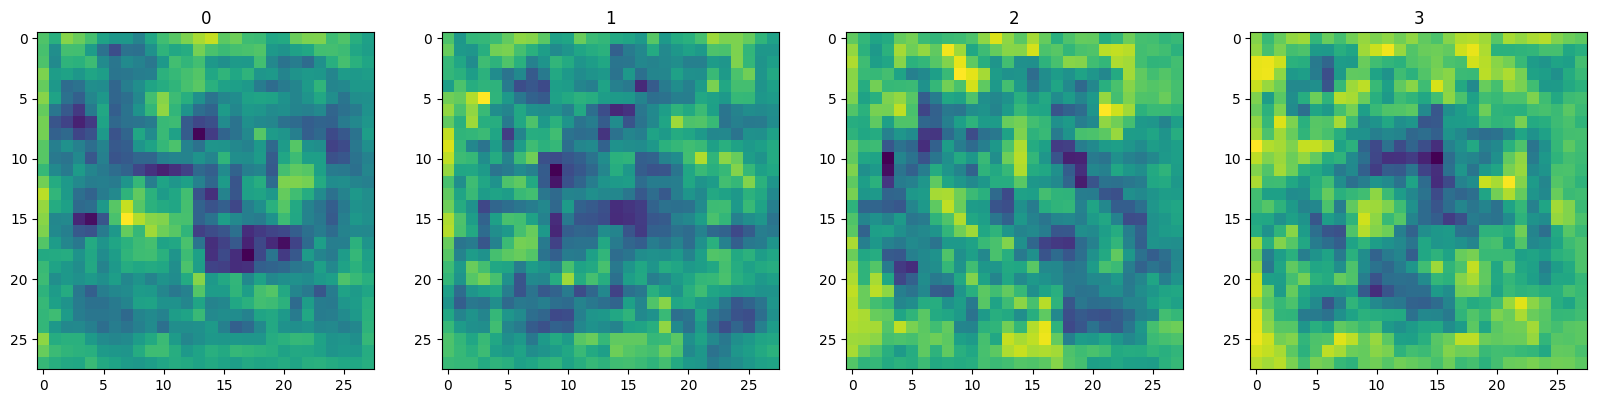

In [11]:
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
    print(img.shape)
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

In [12]:
from tensorflow.keras.layers import MaxPooling2D

In [13]:
def build_discriminator():
    model = Sequential()

    # First Conv Layer
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Second Conv Layer
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Third Conv Layer
    model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Fourth Conv Layer
    model.add(Conv2D(512, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Flatten and Output Layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [14]:
discriminator = build_discriminator()

In [15]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 2, 2, 512)        

In [16]:
img2 = generator.predict(np.random.randn(4,128,1))
discriminator.predict(img2)

1/1 [==============================] - 0s 212ms/step


array([[0.498375  ],
       [0.49832574],
       [0.49835834],
       [0.49831387]], dtype=float32)

In [17]:
# Most Important part of GANs is balancing the generator and discriminator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [18]:
g_opt = Adam(learning_rate=6e-7, weight_decay=5e-4, epsilon=1e-7)
d_opt = Adam(learning_rate=6e-7, weight_decay=5e-4, epsilon=1e-7)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [19]:
from tensorflow.keras.models import Model

In [20]:
tf.random.normal((6,128,1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[ 2.03091651e-01],
        [-2.88320565e+00],
        [ 1.32380736e+00],
        [ 1.24516785e+00],
        [ 4.18585420e-01],
        [ 4.61870059e-02],
        [ 4.86456245e-01],
        [-1.51130641e+00],
        [ 1.11522985e+00],
        [-3.22925523e-02],
        [-3.42618704e-01],
        [ 6.38916492e-01],
        [ 2.78178662e-01],
        [ 3.93680990e-01],
        [-8.32906783e-01],
        [-9.35262144e-01],
        [ 2.42804080e-01],
        [ 5.69687188e-01],
        [ 1.29304469e-01],
        [ 2.49378294e-01],
        [ 6.21159039e-02],
        [ 4.32375431e-01],
        [ 6.55443430e-01],
        [-5.09890139e-01],
        [-1.32075369e+00],
        [-1.55313283e-01],
        [-1.13021159e+00],
        [-6.42114162e-01],
        [-1.35137439e+00],
        [-1.09630191e+00],
        [-6.55728698e-01],
        [-3.90697837e-01],
        [ 1.47230637e+00],
        [ 5.27731538e-01],
        [-1.02842617e+00],
  

In [21]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
    def train_step(self, batch):
        real_img = batch
        fake_img = self.generator(tf.random.normal((6,128,1)), training=False)

        #train the discriminator
        with tf.GradientTape() as d_tape:
            #pass the real and fake images
            yhat_real = self.discriminator(real_img, training=True)
            yhat_fake = self.discriminator(fake_img, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            #create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_real)], axis=0)

            #add some noise to the true outputs
            noise_real= 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake= -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            #calculate loss
            total_d_loss = self.d_loss(yhat_realfake, yhat_realfake)

        #apply backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        #train the generator
        with tf.GradientTape() as g_tape:
            #generate new images
            gen_img = self.generator(tf.random.normal((128,128,1)), training=True)
            #create predicted labels
            predicted_labels = self.discriminator(gen_img, training=False)

            #calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        #apply backpropagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss": total_g_loss}

In [22]:
gan = GAN(generator=generator,discriminator=discriminator)

In [23]:
gan.compile(g_opt=g_opt, g_loss=g_loss, d_opt=d_opt, d_loss=d_loss)

In [24]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [25]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128, save_freq=5):
        super().__init__()
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_freq = save_freq  # Save every `save_freq` epochs

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.save_freq == 0:  # Save images every `save_freq` epochs
            random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images *= 255
            generated_images = generated_images.numpy()
            if not os.path.exists('images'):
                os.makedirs('images')
            for i in range(self.num_img):
                img = array_to_img(generated_images[i])
                img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [26]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [30]:
# Example usage with your GAN model
gan = GAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)
monitor = ModelMonitor(num_img=3, latent_dim=128, save_freq=1)
history = gan.fit(ds, epochs=80)

Epoch 1/80
469/469 [==============================] - 47s 97ms/step - d_loss: 2.8831e-07 - g_loss: 0.0000e+00
Epoch 2/80
469/469 [==============================] - 45s 95ms/step - d_loss: 2.2107e-07 - g_loss: 0.0000e+00
Epoch 3/80
469/469 [==============================] - 45s 96ms/step - d_loss: 1.7158e-07 - g_loss: 0.0000e+00
Epoch 4/80
469/469 [==============================] - 45s 96ms/step - d_loss: 1.3416e-07 - g_loss: 0.0000e+00
Epoch 5/80
469/469 [==============================] - 45s 95ms/step - d_loss: 1.0542e-07 - g_loss: 0.0000e+00
Epoch 6/80
469/469 [==============================] - 45s 97ms/step - d_loss: 8.3344e-08 - g_loss: 0.0000e+00
Epoch 7/80
469/469 [==============================] - 45s 95ms/step - d_loss: 6.8005e-08 - g_loss: 0.0000e+00
Epoch 8/80
469/469 [==============================] - 45s 96ms/step - d_loss: 5.3368e-08 - g_loss: 0.0000e+00
Epoch 9/80
469/469 [==============================] - 45s 95ms/step - d_loss: 4.2752e-08 - g_loss: 0.0000e+00
Epoch 10/8

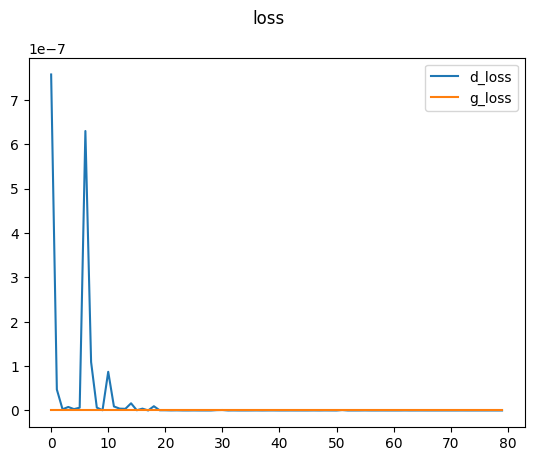

In [31]:
plt.suptitle('loss')
plt.plot(history.history['d_loss'], label='d_loss')
plt.plot(history.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [38]:
imgs = generator.predict(np.random.randn(16,128,1))

1/1 [==============================] - 0s 27ms/step


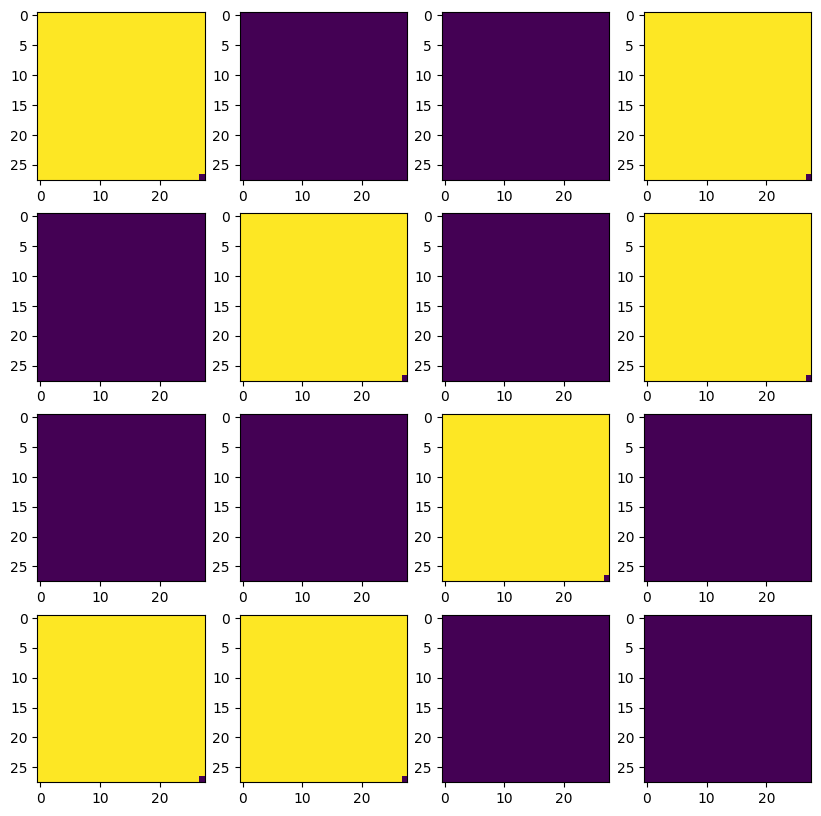

In [39]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

1/1 [==============================] - 0s 31ms/step


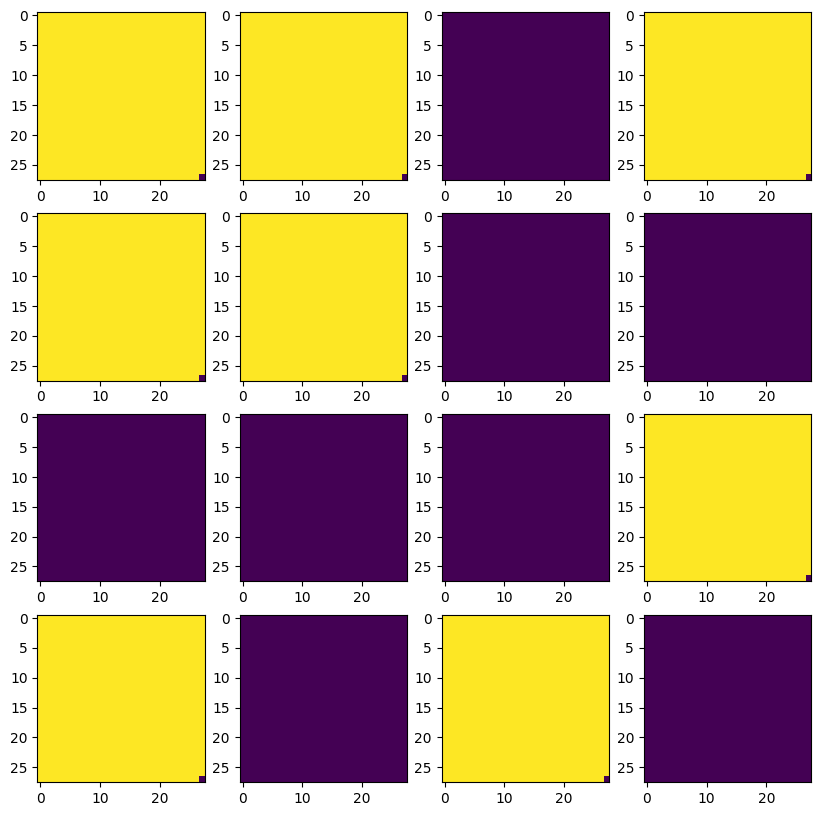

In [42]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])